# Predicting Dengue Disease Spread
## Capstone Project - Machine Learning Engineer Nanodegree
### Giulia Martielli

A competition held by DrivenData.org:
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

<img src="https://images.unsplash.com/photo-1572262086204-3909bfc93ea0?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=751&q=80" alt="Drawing" style="width: 2000px;height: 600px"/>

### Problem Statement

Dengue Fever (**DF**) is a systemic and dynamic infection with a broad clinical spectrum that includes both serious and non-serious clinical manifestations is carried by mosquitos. Its transmission is higly correlated with climate variables, especially temperature and precipitation / humidity. The task of the competition is to predict the number of dengue cases each week (in each of the two locations – San Juan and Iquitos) based on all the environmental variables provided (temperature, precipitation, vegetation, and more).<br>
From a technical point of view, the goal is to predict the `total_cases label` for each triplet (`city`, `year`, `weekofyear`) in the test set.

### Datasets and Inputs

The data for this project are downloaded directly from DrivenData.org (https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/81/). In addition to the number of cases in the two locations, the data include, as previously mentioned, information on temperature, precipitation, humidity, vegetation, and what time of the year the data was obtained. Below a detailed list and description of datasets provided and features - the provided set of information are on a (`year, weekofyear`) timescale, where appropriate, units are provided as a `_unit` suffix on the feature name).<br>


#### Datasets
* `dengue_labels_train.csv` (1,457 rows) containing four columns being city (`sj` for San Juan and `iq` for Iquitos), year (ranging from 1990 to 2008 for San Juan and from 2000 to 2010 for Iquitos), `weekofyear` (ranging from 1 to 53) and `total_cases` (the number of cases/week for each city)
* `dengue_features_train.csv` (1,457 rows) containing data for both San Juan (years ranging from 1990 to 2008) and Iquitos (years ranging from 2000 to 2010), plus all the relevant features, for a total of 24 columns
* `dengue_features_test.csv` (417 rows) containing data for both San Juan (years ranging from 2008 to 2013) and Iquitos (years ranging from 2010 to 2013), plus all the relevant features, for a total of 24 columns; as reported on the DrivenData.org website, “the test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data"

#### Features

***City and date indicators***
*   `city` – City abbreviations: sj for San Juan and iq for Iquitos
*   `week_start_date` – Date given in yyyy-mm-dd format

***NOAA's GHCN daily climate data weather station measurements***
•	station_max_temp_c – Maximum temperature

*   `station_min_temp_c` – Minimum temperature
*   `station_avg_temp_c` – Average temperature
*	  `station_precip_mm` – Total precipitation
*	  `station_diur_temp_rng_c` – Diurnal temperature range


***PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)***
*   `precipitation_amt_mm` – Total precipitation


***NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)***
*   `reanalysis_sat_precip_amt_mm` – Total precipitation
*   `reanalysis_dew_point_temp_k` – Mean dew point temperature
*   `reanalysis_air_temp_k` – Mean air temperature
*   `reanalysis_relative_humidity_percent` – Mean relative humidity
*   `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity
*   `reanalysis_precip_amt_kg_per_m2` – Total precipitation
*   `reanalysis_max_air_temp_k `– Maximum air temperature
*   `reanalysis_min_air_temp_k` – Minimum air temperature
*   `reanalysis_avg_temp_k` – Average air temperature
*   `reanalysis_tdtr_k` – Diurnal temperature range


***Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements***
*   `ndvi_se` – Pixel southeast of city centroid
*   `ndvi_sw` – Pixel southwest of city centroid
*   `ndvi_ne` – Pixel northeast of city centroid
*   `ndvi_nw` – Pixel northwest of city centroid


### Evaluation Metrics
The evaluation metric suggested for the DrivenData.org competition is the _**M**ean **A**bsolute **E**rror_ (**MAE**), which is a model evaluation metric usually used with regression models.

<h1> Analysis </h1>

## Upload data and libraries

Importing data and all needed libraries

In [215]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
from numpy import array
from math import sqrt

from datetime import *

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# xgboost
!pip install xgboost
import xgboost as xgb
print("xgboost", xgb.__version__)
from xgboost import XGBRegressor

# LSTM
!pip install tensorflow
!pip install keras==2.3.1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

%load_ext autoreload
%autoreload 2

plt.style.use('bmh')
pd.options.display.max_rows = 200

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
('xgboost', '0.82')
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More de

In [216]:
df_train = pd.read_csv('data/dengue_features_train.csv') 
df_test = pd.read_csv('data/dengue_features_test.csv') 
dl_train = pd.read_csv('data/dengue_labels_train.csv',sep=';')

In [217]:
df_train=df_train.merge(dl_train,on=['city','year','weekofyear'],how='inner')

## Exploratory Data Analysis

Get a quick introduction of our datasets

In [218]:
## Train set
df_train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [219]:
## Test set
df_test.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [220]:
## Train set
df_train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1451.000000,1451.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1451.000000
mean,2001.026878,26.412130,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.685734
std,5.406124,14.964361,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.653121
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.000000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.000000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.000000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,52.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


In [221]:
# Test set
df_test.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,416.000000,416.000000,373.000000,405.000000,415.000000,415.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,404.000000,404.000000,413.000000,407.000000,411.000000
mean,2010.766827,26.439904,0.126050,0.126803,0.207702,0.201721,38.354324,298.818295,299.353071,295.419179,...,42.171135,82.499810,38.354324,16.927088,5.124569,27.369587,7.810991,32.534625,22.368550,34.278589
std,1.434835,14.978257,0.164353,0.141420,0.079102,0.092028,35.171126,1.469501,1.306233,1.523099,...,48.909514,7.378243,35.171126,1.557868,3.542870,1.232608,2.449718,1.920429,1.731437,34.655966
min,2008.000000,1.000000,-0.463400,-0.211800,0.006200,-0.014671,0.000000,294.554286,295.235714,290.818571,...,0.000000,64.920000,0.000000,12.537143,1.485714,24.157143,4.042857,27.200000,14.200000,0.000000
25%,2010.000000,13.750000,-0.001500,0.015975,0.148670,0.134079,8.175000,297.751429,298.323214,294.335714,...,9.430000,77.397143,8.175000,15.792857,2.446429,26.514286,5.928571,31.100000,21.200000,9.100000
50%,2011.000000,26.000000,0.110100,0.088700,0.204171,0.186471,31.455000,298.547143,299.328571,295.825000,...,25.850000,80.330000,31.455000,17.337143,2.914286,27.483333,6.642857,32.800000,22.200000,23.600000
75%,2012.000000,39.000000,0.263329,0.242400,0.254871,0.253243,57.772500,300.240357,300.521429,296.643571,...,56.475000,88.328929,57.772500,18.174643,8.171429,28.319048,9.812500,33.900000,23.300000,47.750000
max,2013.000000,53.000000,0.500400,0.649000,0.453043,0.529043,169.340000,301.935714,303.328571,297.794286,...,301.400000,97.982857,169.340000,19.598571,14.485714,30.271429,14.725000,38.400000,26.700000,212.000000


Check if there is any **difference between the two cities** San Juan and Iquitos

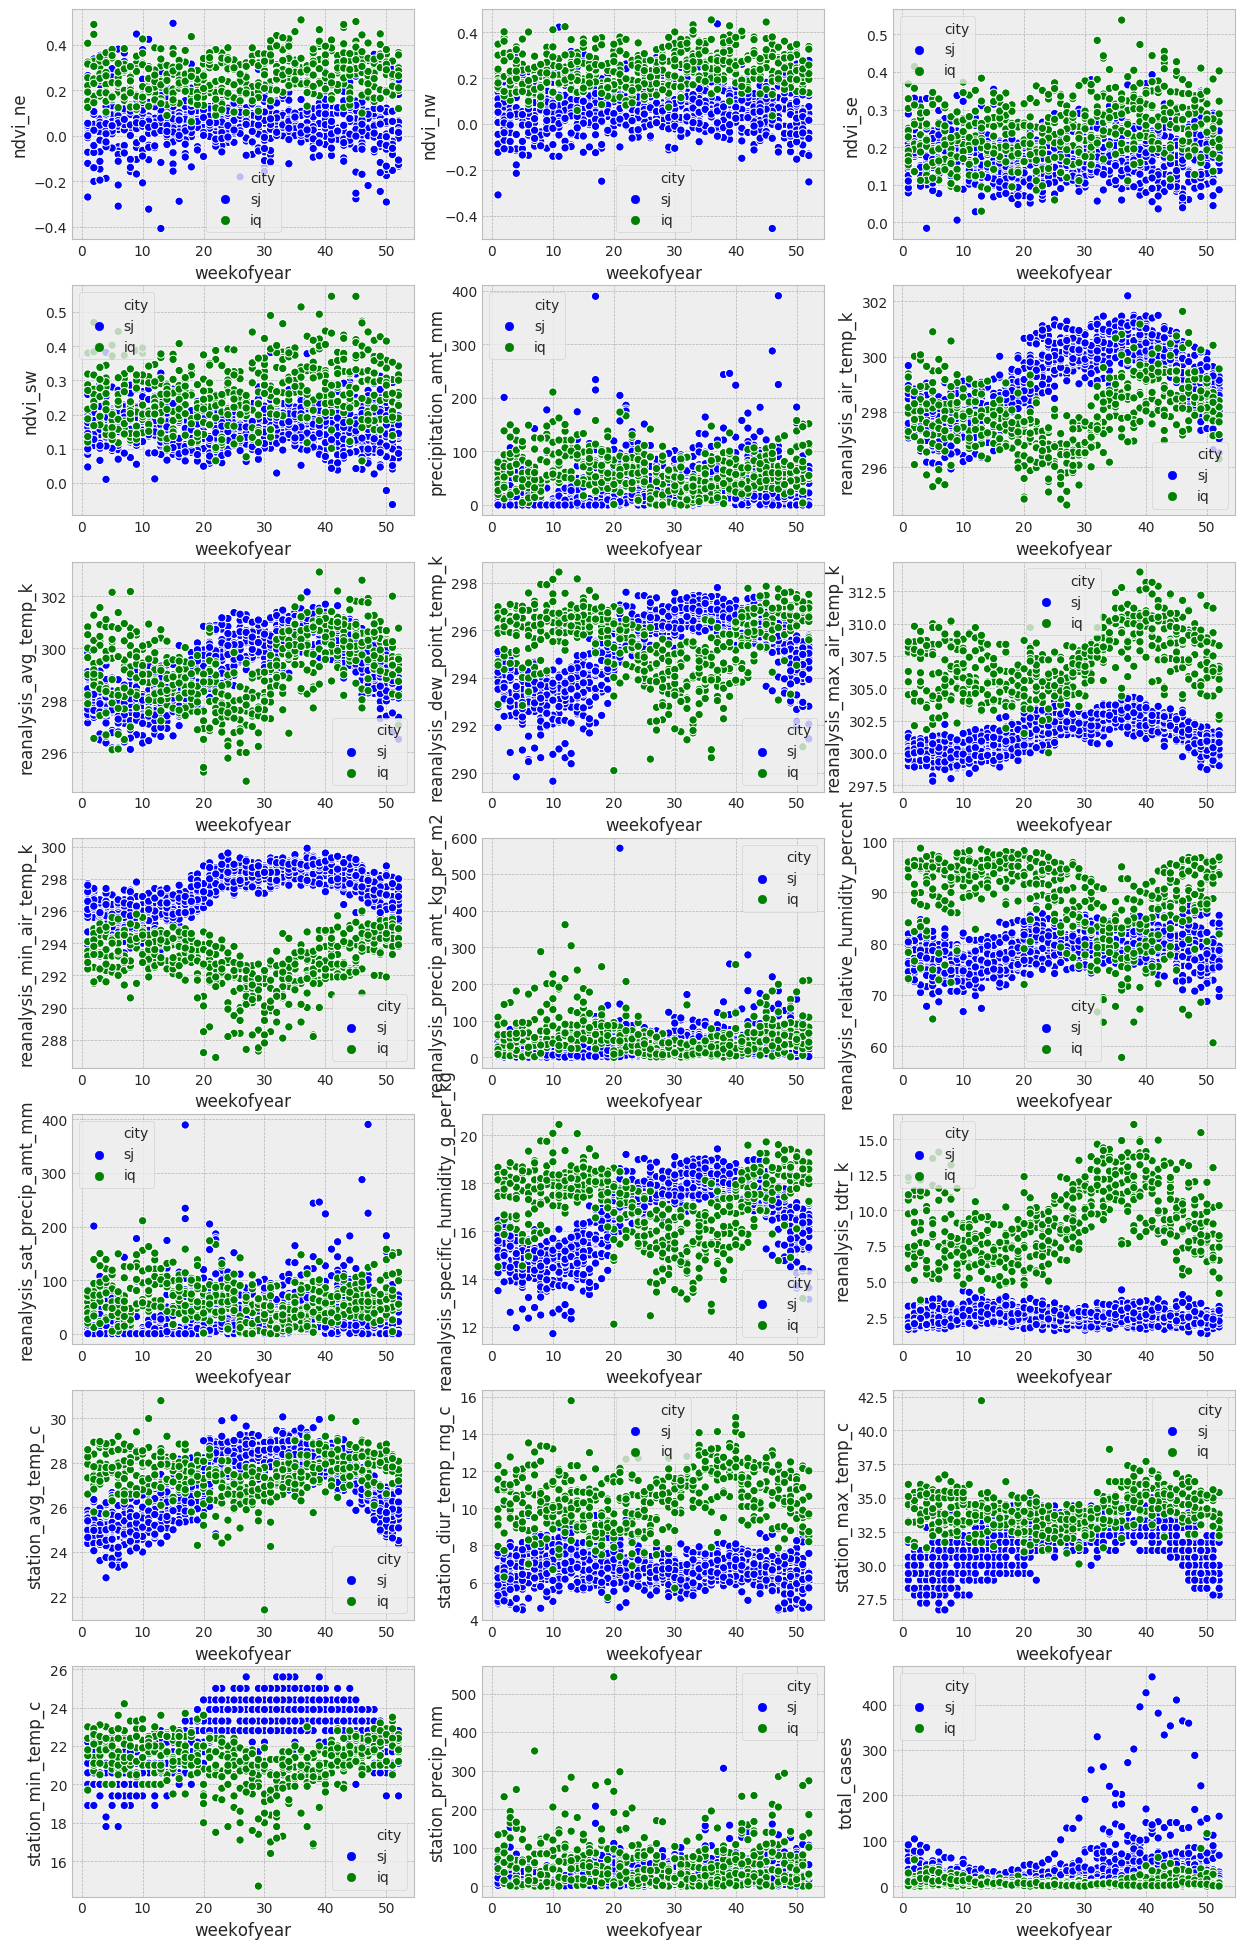

In [222]:
df_train_num = df_train.drop(columns=['year','week_start_date'])

figure(num=None, figsize=(15, 25), dpi=100)
count = 1
for i in range(0,len(df_train_num.columns)-2):
    plt.subplot(7,3,count)
    sns.scatterplot(x="weekofyear", y=df_train_num.columns[i+2],hue="city",data=df_train_num,palette=('blue','green'))
    count+=1
    
plt.show()

Selecting only representative variables for including the plots in the report

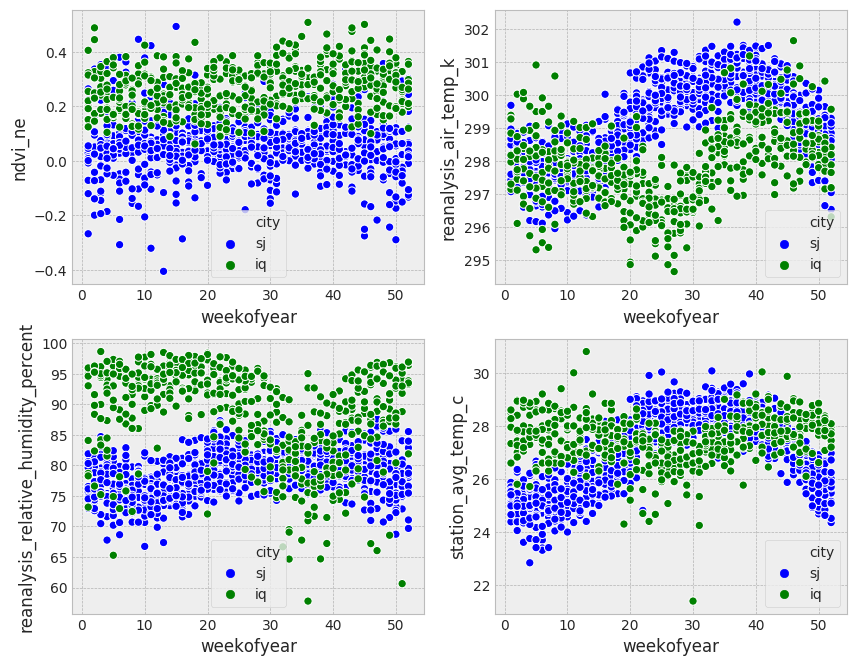

In [223]:
df_train_plot = df_train[['city','weekofyear','ndvi_ne','reanalysis_air_temp_k','reanalysis_relative_humidity_percent','station_avg_temp_c']]

figure(num=None, figsize=(10, 8), dpi=100)
count = 1
for i in range(0,len(df_train_plot.columns)-2):
    plt.subplot(2,2,count)
    sns.scatterplot(x="weekofyear", y=df_train_plot.columns[i+2],hue="city",data=df_train_plot,palette=('blue','green'))
    count+=1
    
plt.show()

The distributions of the variables for the two cities in scope seems very different from each other. Probably due to the fact that San Juan belongs to the Northern hemisphere and Iquitos belongs to the Southern hemisphere. In fact, all the variables related to the distribution of vegetation, and those related to humidity, temperature and precipitation seem to have almost an **opposite behavior** in the two cities with respect to the weeks of the year. For example, in San Juan average temperatures are highest around week 30 of the year (full summer in the Northern hemisphere), as well as humidity is lowest in this period; while on the contrary in Iquitos, the average temperature is highest around weeks 52-1 (corresponding to summer in the Southern hemisphere), as well as humidity is lowest in the same period. 

**_For this reason I decide to treat the two cities separately from now on and fit models separately on them_**

In [224]:
# Separating data for the two cities
df_train_sj = df_train[df_train['city']=='sj']
df_test_sj = df_test[df_test['city']=='sj']
df_train_iq = df_train[df_train['city']=='iq']
df_test_iq = df_test[df_test['city']=='iq']

Next step is to explore features and **check for highly-correlated variables** in the train set that I will be removing during the pre-processing phase

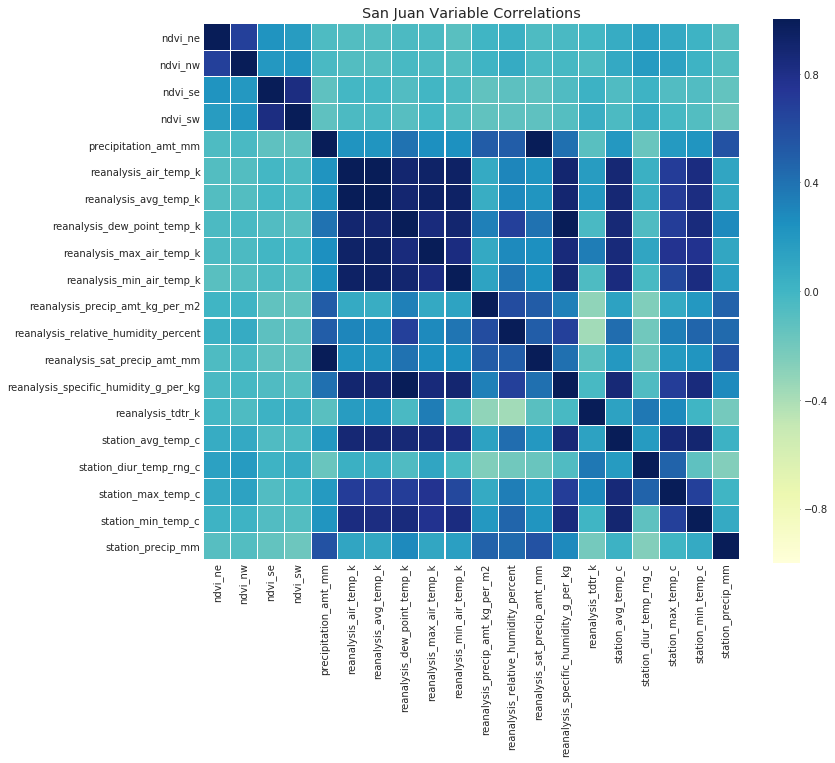

In [225]:
corr = df_train_sj.drop(columns=['city','weekofyear','total_cases','year','week_start_date'],axis=1).corr()
plt.figure(figsize=(12, 10))
plt.title('San Juan Variable Correlations')
sns.heatmap(corr,cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=False, annot_kws={"size": 8}, square=True);

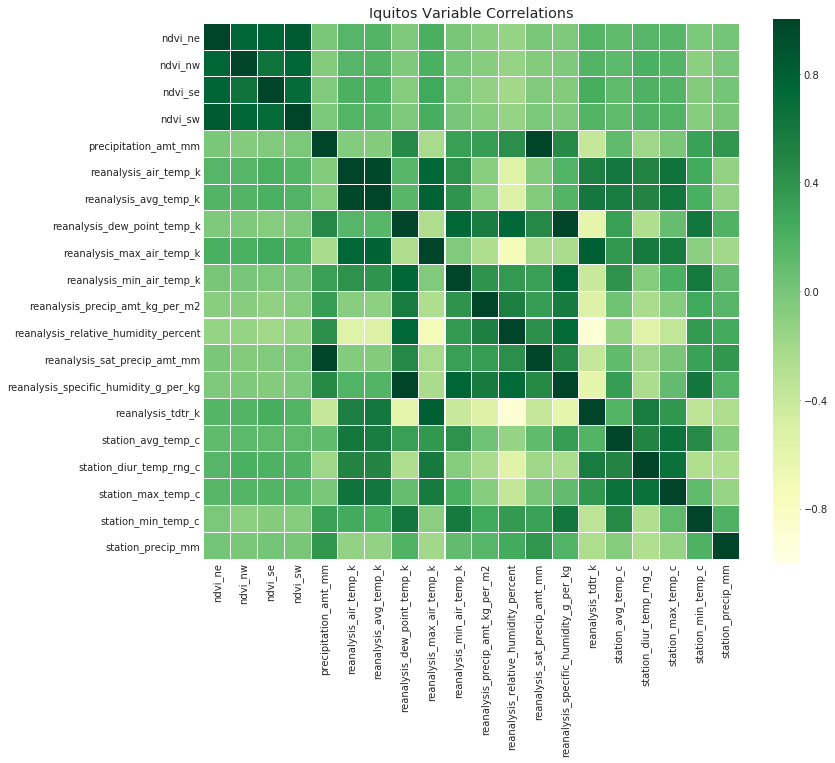

In [226]:
corr = df_train_iq.drop(columns=['city','weekofyear','total_cases','year','week_start_date'],axis=1).corr()
plt.figure(figsize=(12, 10))
plt.title('Iquitos Variable Correlations')
sns.heatmap(corr,cmap='YlGn', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=False, annot_kws={"size": 8}, square=True);

The two plots above show highly correlated features in the train sets for both San Juan and Iquitos. In the data pre-processing section these features will be removed and then the same will be done in the test set, to avoid any data leakage problems, in order to lower model complexity. This difference in the correlations of these cities supports the choice to keep the two cities separate.

Last step is to explore and take a look at the target variable `total_cases` and check for correlations with the features in the dataset.

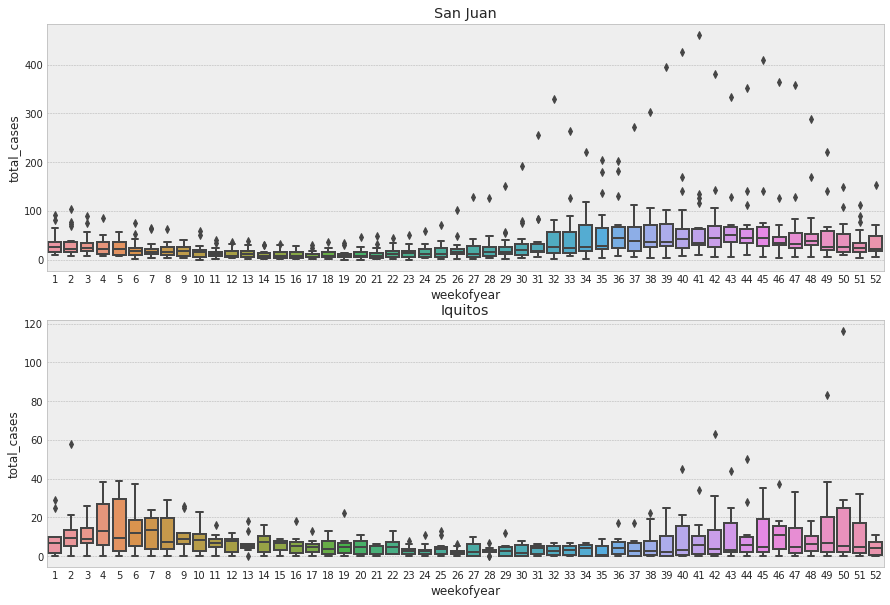

In [227]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(2,1,1)
ax.set_title("San Juan")
sns.boxplot(data=df_train_sj, x='weekofyear', y='total_cases')

ax = plt.subplot(2,1,2)
ax.set_title("Iquitos")
sns.boxplot(data=df_train_iq, x='weekofyear', y='total_cases')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


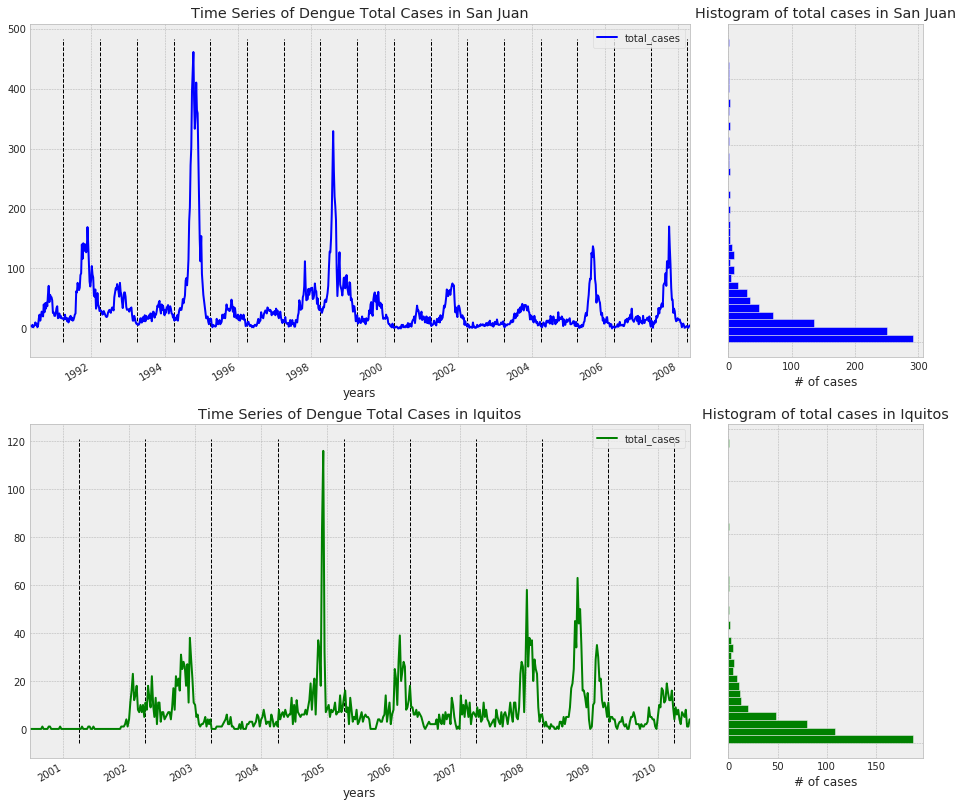

In [228]:
plt.figure(figsize=(16, 15))

ax = plt.subplot2grid((2,4), (0, 0), colspan=3)
df_train_sj["week_start_dt"] = pd.to_datetime(df_train_sj.week_start_date)
df_train_sj.plot(x="week_start_dt", y="total_cases", ax = ax, title="Time Series of Dengue Total Cases in San Juan",
                 color='blue')
plt.xlabel('years')
ymin, ymax = ax.get_ylim()
dt_range = pd.date_range(start=pd.datetime(1990, 4, 1), periods=19, freq=pd.DateOffset(years=1))
ax.vlines(x=dt_range  , ymin=ymin, ymax=ymax-1, linestyles='--', lw=1)

ax = plt.subplot2grid((2,4), (0,3), colspan=1)
ax.set_title("Histogram of total cases in San Juan")
ax.set_xlabel("# of cases")
df_train_sj.total_cases.hist(orientation='horizontal', ax=ax, bins=40,color='blue')
_ = plt.setp(ax.get_yticklabels(), visible=False)

## 
ax = plt.subplot2grid((2,4), (1, 0), colspan=3)
df_train_iq["week_start_dt"] = pd.to_datetime(df_train_iq.week_start_date)
df_train_iq.plot(x="week_start_dt", y="total_cases", ax = ax, title="Time Series of Dengue Total Cases in Iquitos",
                color='green')
plt.xlabel('years')
ymin, ymax = ax.get_ylim()
dt_range = pd.date_range(start=pd.datetime(2000, 4, 1), periods=11, freq=pd.DateOffset(years=1))
ax.vlines(x=dt_range  , ymin=ymin, ymax=ymax-1, linestyles='--', lw=1)

ax = plt.subplot2grid((2,4), (1,3), colspan=1)
ax.set_title("Histogram of total cases in Iquitos")
ax.set_xlabel("# of cases")
df_train_iq.total_cases.hist(orientation='horizontal', ax=ax, bins=40,color='green')
_ = plt.setp(ax.get_yticklabels(), visible=False)

As one can see, San Juan had several peaks of cases in 1995, 1999 and then two more moderate peaks in 2006 and 2008, respectively; while Iquitos had its highest peak of infections in 2005 - a year when cases in San Juan were very low - followed by 2009 and 2008. Once again, the differences between the two cities are confirmed.

In [229]:
# Basic statistics for target variable in the train set

# San Juan
df_train_sj['total_cases'].describe()

count    933.000000
mean      34.184352
std       51.451301
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

In [230]:
# Iquitos
df_train_iq['total_cases'].describe()

count    518.000000
mean       7.577220
std       10.780957
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max      116.000000
Name: total_cases, dtype: float64

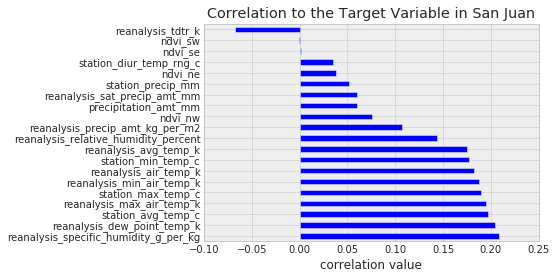

In [231]:
# Compute the correlations to the target variable for San Juan
corr = df_train_sj.drop(columns=['city','weekofyear','year','week_start_date'],axis=1).corr()
plt.title('Correlation to the Target Variable in San Juan')
plt.xlabel('correlation value')
(corr
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(xlim=(-0.1, 0.25),color='blue'))

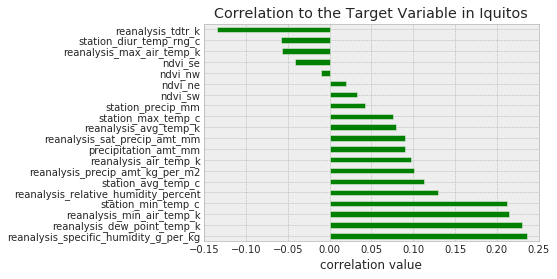

In [232]:
# Compute the correlations to the target variable for Iquitos
corr = df_train_iq.drop(columns=['city','weekofyear','year','week_start_date'],axis=1).corr()
plt.title('Correlation to the Target Variable in Iquitos')
plt.xlabel('correlation value')
(corr
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(xlim=(-0.15, 0.25),color='green'))

<h1><center> Implementation </center></h1>

## Data Pre-processing

Check for **missing values** and impute them with the mean of the features themselves. I choose to calculate mean values on the train set only and use those values for the test set too, in order to avoid any data leakage issue that may arise. This is done for both cities.

In [233]:
## Train set sj
df_train_sj.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  188
ndvi_nw                                   46
ndvi_se                                   16
ndvi_sw                                   16
precipitation_amt_mm                       6
reanalysis_air_temp_k                      3
reanalysis_avg_temp_k                      3
reanalysis_dew_point_temp_k                3
reanalysis_max_air_temp_k                  3
reanalysis_min_air_temp_k                  3
reanalysis_precip_amt_kg_per_m2            3
reanalysis_relative_humidity_percent       3
reanalysis_sat_precip_amt_mm               6
reanalysis_specific_humidity_g_per_kg      3
reanalysis_tdtr_k                          3
station_avg_temp_c                         3
station_diur_temp_rng_c                    3
station_max_temp_c                         3
station_mi

In [234]:
# Impute the NaNs with mean
df_train_sj.fillna(df_train_sj.mean(), inplace=True)
# Check the number of NaN values in each column after imputation
df_train_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [235]:
## Test set sj
# Impute the NaNs with mean
df_test_sj.fillna(df_train_sj.mean(), inplace=True)
# Check the number of NaN values in each column after imputation
df_test_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [236]:
## Train set iq
df_train_iq.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   1
ndvi_nw                                   1
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       35
station_diur_temp_rng_c                  35
station_max_temp_c                       12
station_min_temp_c              

In [237]:
# Impute the NaNs with mean
df_train_iq.fillna(df_train_iq.mean(), inplace=True)
# Check the number of NaN values in each column after imputation
df_train_iq.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [238]:
## Test set iq
# Impute the NaNs with mean
df_test_iq.fillna(df_train_iq.mean(), inplace=True)
# Check the number of NaN values in each column after imputation
df_test_iq.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

Now it's time to check and handle **outliers** in the train and test set. Similarly to the missing values, I will be checking for outliers in the train set and decide on that dataset how to _cap / floor the data_ in both train and test sets.

In [239]:
def treatoutliers (df_train,df_test,factor=1.5):
    columns=df_train.iloc[:,4:24].columns
    print(columns)
    
    for column in columns:
        
        if is_numeric_dtype(df_train[column]):
            
            Q1 = df_train[column].quantile(0.10)
            Q3 = df_train[column].quantile(0.90)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
            df_train[column] = pd.DataFrame(df_train[column].clip(floor, ceil))
            df_test[column] = pd.DataFrame(df_test[column].clip(floor, ceil))
            
        else:
            df_train[column] = pd.DataFrame(df_train[column])
            df_test[column] = pd.DataFrame(df_test[column])
        
    return df_train,df_test

In [240]:
# San Juan
df_train_sj,df_test_sj = treatoutliers(df_train_sj,df_test_sj)

# Iquitos
df_train_iq,df_test_iq = treatoutliers(df_train_iq,df_test_iq)

Index([u'ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm',
       u'reanalysis_air_temp_k', u'reanalysis_avg_temp_k',
       u'reanalysis_dew_point_temp_k', u'reanalysis_max_air_temp_k',
       u'reanalysis_min_air_temp_k', u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm'],
      dtype='object')


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'ndvi_ne', u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'precipitation_amt_mm',
       u'reanalysis_air_temp_k', u'reanalysis_avg_temp_k',
       u'reanalysis_dew_point_temp_k', u'reanalysis_max_air_temp_k',
       u'reanalysis_min_air_temp_k', u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm'],
      dtype='object')


The above function has been inspired by the function available on GitHub at the following linkhttps://gist.github.com/wolframalpha/1681593cfeeeaff25f04f0d77e1dbd6e and it is able to handle outliers by capping / flooring them or even removing them

Heading back to the **highly-correlated** features, I use a function that removes from the train set all the features having a correlation higher than abs(0.90).

In [241]:
def handlecorrelation(df, corr_val):

    # Creates Correlation Matrix and Instantiates
    corr_matrix = df.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = df.iloc[:, (i+1):(i+2)].columns.values
        df = df.drop(col, axis=1)
    return df

In [245]:
# San Juan - run the function four times before stopping
df_train_sj = handlecorrelation(df_train_sj,0.9)
df_train_sj.columns

Index([u'city', u'year', u'weekofyear', u'week_start_date', u'ndvi_ne',
       u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'reanalysis_min_air_temp_k',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm',
       u'total_cases', u'week_start_dt'],
      dtype='object')

In [246]:
df_test_sj = df_test_sj[['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne',
       'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'reanalysis_min_air_temp_k', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'
       ]]
df_test_sj.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_min_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,296.4,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,296.7,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,0.067469,0.151083,0.091529,296.4,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,0.057925,-0.019867,0.124329,0.125686,296.9,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,297.3,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [251]:
# Iquitos - run the function five times before stopping
df_train_iq = handlecorrelation(df_train_iq,0.9)
df_train_iq.columns

Index([u'city', u'year', u'weekofyear', u'week_start_date', u'ndvi_ne',
       u'ndvi_nw', u'ndvi_se', u'ndvi_sw', u'reanalysis_air_temp_k',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm',
       u'total_cases', u'week_start_dt'],
      dtype='object')

In [252]:
df_test_iq=df_test_iq[['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne',
       'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']]
df_test_iq.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,297.648571,82.29,17.654286,9.428571,27.440,10.760,33.8,21.50,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,298.224286,25.30,16.320000,10.157143,27.025,9.625,33.0,21.20,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,297.955714,62.14,18.030000,9.557143,26.950,10.350,33.4,21.60,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,295.715714,47.80,15.394286,7.828571,26.900,9.700,33.3,15.75,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,298.502857,56.30,15.468571,11.771429,27.050,11.850,33.5,16.90,3.0


Now it is time to drop columns that are not correlated to the target variable. As previously seen, for the San Juan data, the features related to vegetation `ndvi_sw` and `ndvi_se` were not correlated to the `total_cases`. So I will be dropping these.

In [253]:
# San Juan
df_train_sj = df_train_sj.drop(columns=['ndvi_sw','ndvi_se','week_start_dt'])
df_test_sj = df_test_sj.drop(columns=['ndvi_sw','ndvi_se'])

# Iquitos
df_train_iq = df_train_iq.drop(columns=['week_start_dt'])

In [254]:
df_train_sj.shape

(933, 16)

In [255]:
df_test_sj.shape

(260, 15)

In [256]:
df_train_iq.shape

(518, 18)

In [257]:
df_test_iq.shape

(156, 17)

## Extreme Gradient Boosting (XGBoost)

**XGBoost** stands for _Extreme Gradient Boosting_ and it is an efficient implementation of the stochastic gradient boosting. It is both fast and efficient and it performs well on a wide range of predictive modelling tasks (Tianqi Chen, C. G., 2016. XGBoost: A Scalable Tree Boosting System, s.l.: ArXiv.Org.)

### San Juan

In [258]:
# San Juan
df_train_sj_y = df_train_sj[['total_cases']].values
df_train_sj_x = df_train_sj.drop(columns=['city','year','weekofyear','week_start_date','total_cases']).values
df_test_sj_x = df_test_sj.drop(columns=['city','year','weekofyear','week_start_date']).values

In [259]:
# Split train data into train and validation sets
test_size = 0.2

#San Juan
df_train_sj_x, df_val_sj_x, df_train_sj_y, df_val_sj_y = train_test_split(df_train_sj_x, df_train_sj_y, test_size=test_size, shuffle=False)

('MAE:', 17.844919786096256)


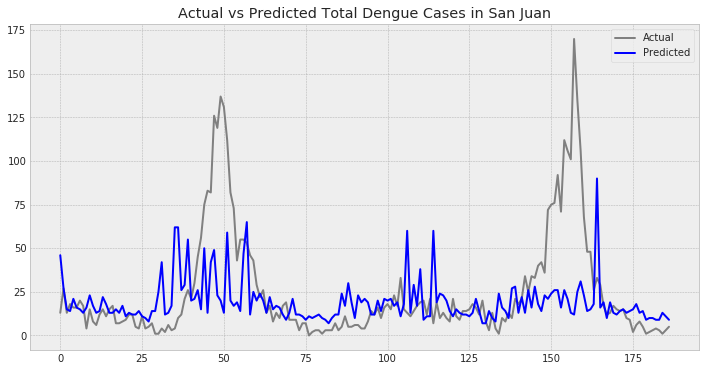

In [260]:
# San Juan
# Fit model to training data
model = xgb.XGBRegressor(n_estimators = 1000, # number of boosted trees
                                learning_rate = 0.001, # step size shrinkage used in update to prevent overfitting
                                max_depth = 10,
                                subsample = 0.8, # subsample ratio of the training set (Stochastic gradient boosting)
                                colsample_bytree = 0.75, 
                                objective ="reg:linear"
                                )
model.fit(df_train_sj_x, df_train_sj_y,eval_metric='mae')

# Make predictions for validation data
y_pred = model.predict(df_val_sj_x)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
MAE = metrics.mean_absolute_error(df_val_sj_y, predictions)
print("MAE:", MAE)

# Plot expected vs predicted
plt.figure(figsize=(12,6))
plt.plot(df_val_sj_y, label='Actual',color='gray')
plt.plot(predictions, label='Predicted',color='blue')
plt.title("Actual vs Predicted Total Dengue Cases in San Juan")
plt.legend()
plt.show()

It looks like the predictions are a little bit "late" in detecting peaks in total cases. I will try to add **Moving Average Rolling Features** to check for improvements

In [261]:
# San Juan
df_train_sj_y = df_train_sj[['total_cases']]
df_train_sj_x = df_train_sj.drop(columns=['city','year','weekofyear','week_start_date','total_cases'])
df_test_sj_x = df_test_sj.drop(columns=['city','year','weekofyear','week_start_date'])

In [262]:
# Create function to add rolling means

def rolling_mean(df, window):
    columns = df.columns
    for col in columns:
        df[col+'_rm'] = df[col].rolling(window).mean()
    return df.fillna(0)

In [263]:
# Rolling means 7 weeks
df_train_sj_x = rolling_mean(df_train_sj_x,7)
df_test_sj_x = rolling_mean(df_test_sj_x,7)

# Rolling means 14 weeks
df_train_sj_x = rolling_mean(df_train_sj_x,14)
df_test_sj_x = rolling_mean(df_test_sj_x,14)

In [264]:
df_train_sj_x = df_train_sj_x.values
df_train_sj_y = df_train_sj_y.values
df_test_sj_x = df_test_sj_x.values

In [265]:
# Split train data into train and validation sets
test_size = 0.2

df_train_sj_x, df_val_sj_x, df_train_sj_y, df_val_sj_y = train_test_split(df_train_sj_x, df_train_sj_y, test_size=test_size, shuffle=False)

('MAE:', 11.491978609625669)


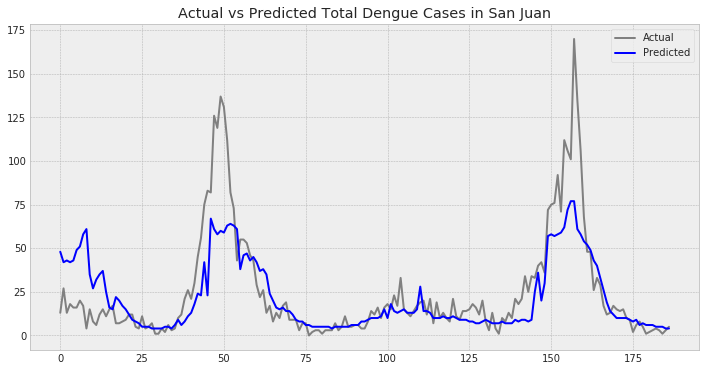

In [266]:
# Fit model to training data
model = xgb.XGBRegressor(n_estimators = 1000, # number of boosted trees
                                learning_rate = 0.001, # step size shrinkage used in update to prevent overfitting
                                max_depth = 10,
                                subsample = 0.8, # subsample ratio of the training set (Stochastic gradient boosting)
                                colsample_bytree = 0.75, 
                                objective ="reg:linear"
                                )
model.fit(df_train_sj_x, df_train_sj_y,eval_metric='mae')

# Make predictions for validation data
y_pred = model.predict(df_val_sj_x)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
MAE = metrics.mean_absolute_error(df_val_sj_y, predictions)
print("MAE:", MAE)

# Plot expected vs predicted
plt.figure(figsize=(12,6))
plt.plot(df_val_sj_y, label='Actual',color='gray')
plt.plot(predictions, label='Predicted',color='blue')
plt.title("Actual vs Predicted Total Dengue Cases in San Juan")
plt.legend()
plt.show()

By adding rolling means at 7 and 14 weeks for all the chosen features the MAE score gets definitely better. It is time now to fit the model and **make predictions** on the test set

In [267]:
final_xgb_predictions_sj = model.predict(df_test_sj_x)

### Iquitos

In [268]:
# Iquitos
df_train_iq_y = df_train_iq[['total_cases']].values
df_train_iq_x = df_train_iq.drop(columns=['city','year','weekofyear','week_start_date','total_cases']).values
df_test_iq_x = df_test_iq.drop(columns=['city','year','weekofyear','week_start_date']).values

In [269]:
# Split train data into train and validation sets
test_size = 0.2

# Iquitos
df_train_iq_x, df_val_iq_x, df_train_iq_y, df_val_iq_y = train_test_split(df_train_iq_x, df_train_iq_y, test_size=test_size, shuffle=False)

('MAE:', 7.0576923076923075)


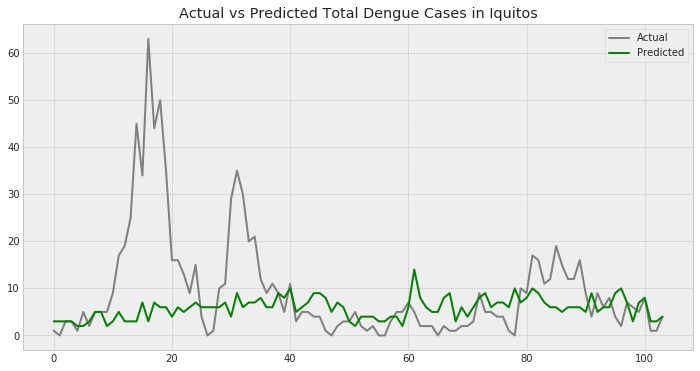

In [270]:
# Iquitos
# Fit model to training data
model = xgb.XGBRegressor(n_estimators = 150, # number of boosted trees
                                learning_rate = 0.01, # step size shrinkage used in update to prevent overfitting
                                subsample = 0.8, # subsample ratio of the training set (Stochastic gradient boosting)
                                colsample_bytree = 0.75
                                )
model.fit(df_train_iq_x, df_train_iq_y,eval_metric='mae')

# Make predictions for validation data
y_pred = model.predict(df_val_iq_x)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
MAE = metrics.mean_absolute_error(df_val_iq_y, predictions)
print("MAE:", MAE)

# Plot expected vs preducted
plt.figure(figsize=(12,6))
plt.plot(df_val_iq_y, label='Actual',color='gray')
plt.plot(predictions, label='Predicted',color='green')
plt.title("Actual vs Predicted Total Dengue Cases in Iquitos")
plt.legend()
plt.show()

In this case, the model is clearly too _timid_, meaning that it does not catch the peaks of total dengue cases at all and at the same time it seems like it is overfitting. I will try to add **Moving Average Rolling Features** to check for improvements

In [271]:
# Iquitos
df_train_iq_y = df_train_iq[['total_cases']]
df_train_iq_x = df_train_iq.drop(columns=['city','year','weekofyear','week_start_date','total_cases'])
df_test_iq_x = df_test_iq.drop(columns=['city','year','weekofyear','week_start_date'])

In [272]:
# Rolling means 1 week
df_train_iq_x = rolling_mean(df_train_iq_x,1)
df_test_iq_x = rolling_mean(df_test_iq_x,1)

# Rolling means 5 weeks
df_train_iq_x = rolling_mean(df_train_iq_x,5)
df_test_iq_x = rolling_mean(df_test_iq_x,5)

# Rolling means 10 weeks
df_train_iq_x = rolling_mean(df_train_iq_x,10)
df_test_iq_x = rolling_mean(df_test_iq_x,10)

# Rolling means 15 weeks
df_train_iq_x = rolling_mean(df_train_iq_x,15)
df_test_iq_x = rolling_mean(df_test_iq_x,15)

In [273]:
df_train_iq_x = df_train_iq_x.values
df_train_iq_y = df_train_iq_y.values
df_test_iq_x = df_test_iq_x.values

In [274]:
# Split train data into train and validation sets
test_size = 0.2

df_train_iq_x, df_val_iq_x, df_train_iq_y, df_val_iq_y = train_test_split(df_train_iq_x, df_train_iq_y, test_size=test_size, shuffle=False)

('MAE:', 6.365384615384615)


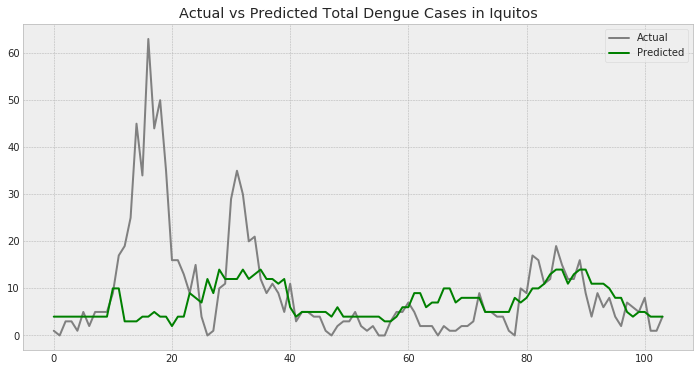

In [275]:
# Iquitos
# Fit model to training data
model = xgb.XGBRegressor(n_estimators = 10, # number of boosted trees
                                learning_rate = 0.15, # step size shrinkage used in update to prevent overfitting
                                subsample = 0.8, # subsample ratio of the training set (Stochastic gradient boosting)
                                colsample_bytree = 0.75
                                )
model.fit(df_train_iq_x, df_train_iq_y,eval_metric='mae')

# Make predictions for validation data
y_pred = model.predict(df_val_iq_x)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
MAE = metrics.mean_absolute_error(df_val_iq_y, predictions)
print("MAE:", MAE)

# Plot expected vs preducted
plt.figure(figsize=(12,6))
plt.plot(df_val_iq_y, label='Actual',color='gray')
plt.plot(predictions, label='Predicted',color='green')
plt.title("Actual vs Predicted Total Dengue Cases in Iquitos")
plt.legend()
plt.show()

After several tryals, I added adding rolling means at 1, 5, 10 and 15 weeks for all the chosen features, however the MAE score does not get that much better, although the model seems to be less _timid_ but still quite overfitting. I will try to fit the model and **make predictions** on the test set

In [276]:
final_xgb_predictions_iq = model.predict(df_test_iq_x)

## Long Short-Term Memory (LSTM)

**Long Short-Term Memory** networks - usually simply called "LSTM" - are a special type of RNN that can handle long-term dependencies (rownlee, J., 2020. How to Use XGBoost for Time Series Forecasting, s.l.: Machine Learning Mastery.). For this reason, they are among the most widely used types of neural networks to date. 

### San Juan

In [325]:
# San Juan
df_train_sj_y = df_train_sj[['total_cases']].values
df_train_sj_x = df_train_sj.drop(columns=['city','year','weekofyear','week_start_date','total_cases']).values
df_test_sj_x = df_test_sj.drop(columns=['city','year','weekofyear','week_start_date'])#.values

In [326]:
# Split train data into train and validation sets
test_size = 0.2

#San Juan
df_train_sj_x, df_val_sj_x, df_train_sj_y, df_val_sj_y = train_test_split(df_train_sj_x, df_train_sj_y, test_size=test_size, shuffle=False)

In [327]:
df_train_sj_x.shape

(746, 11)

In [328]:
df_train_sj_y.shape

(746, 1)

In [329]:
df_val_sj_x.shape

(187, 11)

In [330]:
df_val_sj_y.shape

(187, 1)

**Prepare Data**<br>
The data must be prepared before we can use it to train an LSTM and transformed appropriately in order to be fed to the Neral Network.

Specifically, two additional changes are required:
 
- Scale. The scale of the data must be reduced to values between -1 and 1, the activation function of the LSTM units
- Differentiate. Create lagged features to the data, since in a time series problems, we have to predict a value at time T, based on the data from days T-N where N can be any number of steps
- Create a tridimentional matrix, which is the format accepted from the LSTM as data input<br>

[https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/]

Data normalization with `MinMaxScaler` function from the `sklearn.preprocessing` library to scale the data between 0 and 1

In [331]:
scaler = MinMaxScaler(feature_range = (0, 1))
df_train_sj_x = scaler.fit_transform(df_train_sj_x)
df_val_sj_x = scaler.fit_transform(df_val_sj_x)

Creating lagged features, timesteps = 10 (weeks)

In [332]:
def lagged_df(data, lag):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in reversed(range(1, lag))]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [333]:
df_train_sj_x = lagged_df(df_train_sj_x,10)
df_val_sj_x = lagged_df(df_val_sj_x,10)

In [334]:
df_train_sj_x.shape[1]

110

In [337]:
df_val_sj_x.shape[1]

110

In order to train LSTM on our data, we need to convert data into the shape accepted by the LSTM. I need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset. The second dimension is the number of time steps which is 10, while the last dimension is the number of indicators

In [338]:
df_train_sj_x = np.array(df_train_sj_x)
df_val_sj_x = np.array(df_val_sj_x)

df_train_sj_x = np.reshape(df_train_sj_x, (df_train_sj_x.shape[0], 10, 11))
df_val_sj_x = np.reshape(df_val_sj_x, (df_val_sj_x.shape[0], 10, 11))

**Train the LSTM**<br>
As a first step, I need to instantiate the Sequential class

In [370]:
model = Sequential()

Adding LSTM layer to the model that I just created

In [371]:
model.add(LSTM(units=100, return_sequences=True, input_shape=(10, 11)))

Adding a dropout layer to the model, to avoid over-fitting

In [377]:
model.add(Dropout(0.9))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

To make our model more robust, I add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since I want to predict a single value in the output.

In [378]:
model.add(Dense(units = 1))

It's time to compile the LSTM before training it on the training data. I use the MAE as loss function and to reduce the loss or to optimize the algorithm, we use the _adam optimizer_

In [379]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [375]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 100)           44800     
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 10, 1)             101       
Total params: 44,901
Trainable params: 44,901
Non-trainable params: 0
_________________________________________________________________


Time to train the model

In [ ]:
lstm = model.fit(df_train_sj_x,df_train_sj_y,validation_data = (df_val_sj_x,df_val_sj_y), epochs = 100, batch_size = 32)

Train on 746 samples, validate on 187 samples
Epoch 1/100
746/746 [==============================] - 3s 4ms/step - loss: 4283.7230 - mean_absolute_error: 35.4197 - val_loss: 1291.3743 - val_mean_absolute_error: 19.4709
Epoch 2/100
746/746 [==============================] - 1s 924us/step - loss: 3815.1825 - mean_absolute_error: 29.5133 - val_loss: 1169.1422 - val_mean_absolute_error: 18.1271
Epoch 3/100
746/746 [==============================] - 1s 924us/step - loss: 3658.9948 - mean_absolute_error: 28.1010 - val_loss: 1127.0503 - val_mean_absolute_error: 17.8931
Epoch 4/100
746/746 [==============================] - 1s 936us/step - loss: 3584.5905 - mean_absolute_error: 27.4976 - val_loss: 1097.2578 - val_mean_absolute_error: 17.8622
Epoch 5/100
746/746 [==============================] - 1s 934us/step - loss: 3523.6342 - mean_absolute_error: 27.0942 - val_loss: 1072.1638 - val_mean_absolute_error: 17.9322
Epoch 6/100
746/746 [==============================] - 1s 945us/step - loss: 3485

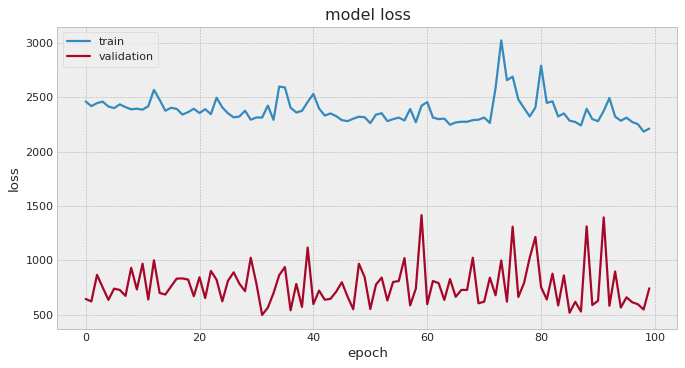

In [369]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

# Loss Train / Val
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Prepare Data**<br>
The data must be prepared before we can use it to train an LSTM and transformed from a series into a supervised learning problem.

Specifically, two additional changes are required:

- Stationary. The data shows an increasing trend that must be removed by differencing 
- Scale. The scale of the data must be reduced to values between -1 and 1, the activation function of the LSTM units.<br>

We can introduce a function to make the data stationary called difference(). This will transform the series of values into a series of differences, a simpler representation to work with. [https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/]

In [113]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [114]:
df_train_sj_x = difference(df_train_sj_x)
df_test_sj_x = difference(df_test_sj_x)

We can use the _MinMaxScaler_ from the `sklearn` library to scale the data.

In [115]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    return supervised_values

In [121]:
# prepare data
df_train_sj_x = prepare_data(df_train_sj_x, 5, 3)

[autoreload of scipy.special failed: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name specfun
]
[autoreload of scipy.sparse.linalg.dsolve failed: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name _add_newdocs
]
[autoreload of scipy.cluster failed: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name vq
]
[autoreload of scipy.optimize.cobyla failed: Traceback (most recent call last):
  File "/home

ValueError: setting an array element with a sequence.

In [82]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [90]:
df_train_sj_x  = series_to_supervised(df_train_sj_x, 1, 4)
df_val_sj_x = series_to_supervised(df_val_sj_x, 1, 4)

In [ ]:
results = np.reshape(df_train_sj_y, (-1,1))
scaler_x = MinMaxScaler()
print(scaler_x.fit(newtraindf))
xscale = scaler_x.transform(newtraindf)

In [60]:
def lstm_preprocessing(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a) 
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX)

In [61]:
df1,df2=create_dataset(df_train_sj_x,3)

In [68]:
df1.shape

(929, 3)

In [ ]:

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [67]:
df_train_sj_x.shape

(933, 11)

In [ ]:
# Create function to add rolling means

def rolling_mean_future(df,window):
    columns = df.columns
    for col in columns:
        df[col+'_rmf'] = df[col].rolling(window).mean().shift(-1)
    return df.fillna(0)